# Projet RAKUTEN - Text Mining


## 1. Presentation

L'objectif est d'obtenir le meilleur score possible ([weighted F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html?highlight=f1%20score#sklearn.metrics.f1_score)) par des méthodes de machine learning de la librairie [scikit-learn](https://scikit-learn.org/stable/).

A chaque échantillon du jeu de données est associé un texte qui est la concatenation des champs **designation** et **description** (ce dernier pouvant être vide). Le texte est ensuite vectorisé à l'aide de la fonction [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html?highlight=tfidfvectorizer#sklearn.feature_extraction.text.TfidfVectorizer). La matrice np.array obtenue est ensuite passée en entrée d'un classificateur au travers d'un pipe ([pipeline](https://scikit-learn.org/stable/modules/classes.html?highlight=pipe#module-sklearn.pipeline)) et le score obtenu est comparé à celui des autres classificateurs.

## 2. Sélection initiale des classificateurs
Les premiers essais ont été effectués avec un jeu de données réduit aux 20000 premiers échantillons (16000 pour l'entrainement et 4000 pour le test), afin de raccourcir les temps d'exécution. Plusieurs classificateurs ont été testés afin d'identifier les plus prometteurs.  
  Durant cette étape, très peu de tuning a été effectué sur le tokenizer et la fonction TfidfVectorizer. 
  La fonction [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) a permis de faire une sélection de base des paramètres de chacun de ces classificateurs.

|  score | Classificateur      | Principaux paramètres             |
|--------|:--------------------|:----------------------------------|
| 0.7777 | SVC                 | C=10 kernel=linear                |
| 0.7665 | LinearSVC           | dual=False penalty=l2             |
| 0.7578 | LogisticRegression  | class_weight=balanced max_iter=200|
| 0.7442 | SGDClassifier       | penaly=l2                         |
| 0.7378 | MLPClassier         | hidden_layer_sizes=10 max_iter=40 |
| 0.6344 | GaussianNB          | var_smoothing=1e-08               |
| 0.6032 | KNeighborClassifier | metric=minkowski n_neighbors=4    |
| 0.5476 | BernoulliNB         | alpha=0.3                         |
| 0.1702 | RandomForest        | criterion=entropy max_depth=5     |


## 3. Essais sur les classificateurs retenus

Des essais supplémentaires ont été faits avec les classificateurs identifiés comme les meilleurs, en changeant les paramètres des classificateurs eux-mêmes mais aussi de tfidfVectorizer. Le tokenizer utilisé étant toujours celui de [Spacy](https://spacy.io/).

|  score | Durée(s) | Classifier          | Principaux paramètres                      |
|--------|:---------|:--------------------|:-------------------------------------------|
| 0.7929 |  184     | SVC                 | kernel=linear decision_function_shape=ovo  |
| 0.7863 |   10     | LinearSVC           | penalty=l1 dual=False 
| 0.7792 | 1466     | MLPClassifier       | layer_sizes=40, max_iter=40                |
| 0.7708 |  109     | LogisticRegression  | class_weight=balanced max_iter=200         |
| 0.6459 |    4     | KNeighborClassifier | n_neighbors=5  metric=minkowski            |                            

Quelques essais ont été faits avec des méthodes ensemble. L'utilisation de AdaBoostClassifier ne donne rien (peut être une mauvaise manip), le XGBoost n'a pas été essayé.

|  score | Durée(s) | Classifier       | Principaux paramètres                                       |
|--------|:----------|:----------------|:------------------------------------------------------------|
| 0.7885 | 295      | VotingClassifier | estimator=(knn, lr, svc) voting=hard weights=(1,2,2)        |
| 0.7835 | 308      | VotingClassifier | estimator=(knn, lr, svc) voting=hard weights=None           |
| 0.7628 | 1630     | StackingClassifer| estimator=(knn, lr, svc) final_estimator=LogisticRegression |  


Au final, le MLP semble interessant mais il est trop lent sur un PC de base. SVC(linear) et [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) qui sont similaires donnent les meilleurs scores, le dernier est plus interessant car beaucoup plus rapide, sans doute en raison de son implémentaion dans scikit-learn.

La fonction python **evaluate_model()** définie dans ce notebook a été utilisée pour évaluer les modèles et afficher leurs performances. 


## 4. Tuning sur LinearSVC

Dans cette phase, du réglage itératif a été fait sur les différents éléments suivants:
  * Le **tokenizer**: utilisation de Spacy ou du tokenizer par défault de scikit-learn, utilisation du lemmatizer, passage ou non en minuscule, suppression ou non des accents, suppression ou non des balises html (qu'on observe dans plusieurs échantillons), etc.
  * **tfidfVectorizer**: strip_accents, stop_words, max_df, min_df, ngram_range, use_idf, smooth_idf, sublinear_tf, binary
  * **LinearSVC**: penalty, C, dual, tol, max_depth

Afin d'optimiser le temps des tests, la fonction python **evaluate_tfclf_step_by_step()** a été utilisée. Cette fonction définie ci-dessous évalue le modèle en commençant par une taille de 4000 et en augmentant le nombre d'échantillons par pas de 5000. Ainsi, on peut laisser le test se dérouler tant qu'on observe une amélioration par rapport à un test précédent ou bien l'interrompre; les résultats sont stockés dans un fichier [pickle](https://docs.python.org/3/library/pickle.html) au fur et à mesure, ainsi si le programe est interrompu, il repart de là où il était: Il faut penser à effacer ce fichier cache avant d erelancer untest depuis le début.


## 5. Code commun

Ci dessous les fonctions utilisées dans ce notebook.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import pickle
import time
import html
import os
import re

import spacy
import nltk
from nltk.corpus import stopwords

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import f1_score, make_scorer, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier


def f1_score_w(y_true, y_pred, **kwargs):
    """
    Score utilisé par Rakuten
    """
    return f1_score(y_true, y_pred, average='weighted')


def read_X(X_file):
    """
    Lecture d'un fichier de données (dataframe) X et petit nettoyage

    """
    df = pd.read_csv(X_file)
    # La première colonne est un doublon:
    #          df["Unnamed: 0"] == df.index 
    df = df.drop("Unnamed: 0", axis=1)
    # Les colonnes designation et description sont à l'origine de type objet
    #          df.info()
    df.designation = df.designation.astype('string')
    df.description = df.description.astype('string')
    return df


def remove_accents(text):
    """
    Supprime les accents du texte <text>
    """
    accents = { 'a': ['à', 'ã', 'á', 'â'],
                'e': ['é', 'è', 'ê', 'ë'],
                'i': ['î', 'ï'],
                'u': ['ù', 'ü', 'û'],
                'o': ['ô', 'ö'] }
    for ch in accents:
        for chacc in accents[ch]:
            text = text.replace(chacc, ch)
    return text


#reclean = re.compile(r"(\<.*?\>|\&\#\d+\;)")
def X_text(X):
    """
    A partir d'un dataframe X retourne une liste de textes (un par échantillon
    du dataframe X)
    """
    lst = []
    for desc, desi in zip(X.description, X.designation):
        descstr = desc if type(desc) == str else ''
        desistr = desi if type(desi) == str else ''
        sep = ' ' if type(desc) == str and type(desi) == str else ''
        s = descstr + sep + desistr
        #s = reclean.sub(' ', s)
        #s = html.unescape(s)
        #s = re.sub(r"(\<)", " \1",s)
        #s = re.sub(r"(\>)", "\1 ",s)
        s = s.lower() + ' ' + re.sub(r"([^A-Z0-9°\+\*\=]+)","",s).lower()
        lst.append(s)
    return lst


spacynlp = None
spacyre = re.compile(r"(<.*?>|&#\d+;|\'|\:|\.|\-|\+)")
french_stop_words = set(stopwords.words('french'))
french_stop_words_no_accent = [remove_accents(x) for x in french_stop_words]
def tokenize_spacy(sentence):
    """
    Tokenizer basé sur spacy
    """
    global spacynlp
    if spacynlp is None:
        spacynlp = spacy.load("fr_core_news_sm")
        spacynlp.disable_pipes ('tagger', 'parser', 'ner')
    s = sentence
    t = [x.lemma_ for x in spacynlp(s)]
    #t = [x.text for x in spacynlp(s) if not x.text in french_stop_words]
    return t


def evaluate_model(name, model, X_trn, X_tst, y_trn, y_tst):
    """
    Entraine un modèle <model> nommé <name> et affiche son score
    """
    start = time.time()
    model.fit(X_trn, y_trn)
    y_pred = model.predict(X_tst)
    stop = time.time()
    score = f1_score_w(y_tst, y_pred)
    print(f"{name:<15} weighted-F1-score = {round(score,5)} ({round(stop-start,2)}s)")
    return model


def evaluate_tfclf_step_by_step(name, clf):
    """
    Entraine le model <clf> nommé <name> avec des tailles croissantes d'échantillons
    et affiche une synthèse à la fin
    """
    def display_progress(df, nb):
        r = df.loc[nb]
        print(f"nb={nb} w-f1-score={r.score} ({int(r.vocalen)} mots, {r.time} sec)")
    
    X0 = read_X("X_train_update.csv")
    y0 = pd.read_csv("Y_train_CVw08PX.csv").drop("Unnamed: 0", axis=1)["prdtypecode"]
    test_size = 0.20
    X, y = shuffle(X_text(X0), y0, random_state=51)
    filename = name + ".pkl"
    if os.path.isfile(filename):
        df = pd.read_pickle(filename)
    else:
        df = pd.DataFrame({'nb':[], 'score':[], 'vocalen':[], 'time': []})

    for nb in range(4000, len(X), 8000):
        if nb in df.index:
            display_progress(df, nb)
            continue
        X_trn, X_tst, y_trn, y_tst = train_test_split(X[:nb], y[:nb], shuffle=True, random_state=51)
        now = datetime.datetime.now().strftime("%Hh%Mmn")
        print(f"... Evaluation avec {nb} échantillons ({now}) ...")
        start = time.time()
        clf.fit(X_trn, y_trn)
        y_pred = clf.predict(X_tst)
        vocalen = len(clf[0].vocabulary_)
        stop = time.time()
        delta = round(stop-start,2)
        score = round(f1_score_w(y_tst, y_pred), 5)
        df.loc[nb] = [nb, score, vocalen, delta]
        display_progress(df, nb)
        df.to_pickle(filename)    

    # Affichage
    filename = name + ".pkl"
    if not os.path.isfile(filename):
        print(f"File {filename} not found!")
        return
    df = pd.read_pickle(filename)
    plt.figure(figsize=(12,4))
    ax1 = plt.subplot(1,1,1)
    ibest = df.score.sort_values().index[-1:]
    bestnb = np.float(df.nb[ibest])
    bestscore = np.float(df.score[ibest])
    plt.plot(df.nb, df.score,c='b', label='weighted F1 score')
    plt.plot(np.array([0, bestnb, bestnb], dtype=object),
             np.array([bestscore, bestscore, 0], dtype=object))
    plt.title(f"Score = {bestscore} pour {int(bestnb)} échantillons")
    plt.xlim(4000, df.nb.max() + 1000)
    plt.ylim(0.5, 1)
    plt.xlabel("Nombre d'échantillons")
    plt.ylabel("Score")
    plt.legend()
    plt.show()


## 6. Resultats obtenus

Le meilleur classificateur et ses résultats (weighted F1 score) pour des échantillons de tailles croissantes, suivi d'une évaluation sur le jeu complet (en utilisant 20% d'échantillon pour les tests) et affichage du rapport de classification ainsi que de la matrice de confusion.

nb=4000 w-f1-score=0.69037 (38828 mots, 16.1 sec)
nb=12000 w-f1-score=0.77259 (97274 mots, 23.63 sec)
nb=20000 w-f1-score=0.80088 (147041 mots, 36.48 sec)
nb=28000 w-f1-score=0.80738 (193450 mots, 48.02 sec)
nb=36000 w-f1-score=0.82238 (238859 mots, 61.07 sec)
nb=44000 w-f1-score=0.83046 (279268 mots, 75.73 sec)
nb=52000 w-f1-score=0.83586 (317898 mots, 97.79 sec)
nb=60000 w-f1-score=0.84087 (355611 mots, 112.35 sec)
nb=68000 w-f1-score=0.84643 (394333 mots, 127.37 sec)
nb=76000 w-f1-score=0.84219 (425607 mots, 136.0 sec)
nb=84000 w-f1-score=0.84828 (462003 mots, 152.96 sec)


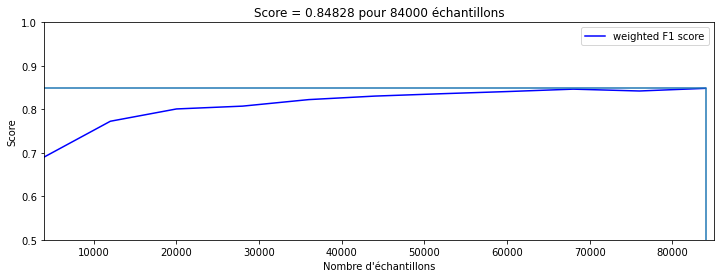

In [11]:
#
# Meilleur classifier
#
clf_linearsvc = make_pipeline(
    TfidfVectorizer(analyzer='word',
                  tokenizer=tokenize_spacy,
                      #strip_accents='unicode',
                      #stop_words=french_stop_words_no_accent, # peut etre interessant parce que lisse la progression
                  max_df=0.8,
                  min_df=2,
                  ngram_range=(1,2),
                  use_idf=True,
                  smooth_idf=True,
                  sublinear_tf=False,
                  binary=True,
                  ),
    LinearSVC(penalty="l2", dual=True, C=0.8, tol=1e-5, max_iter=4000),
)
evaluate_tfclf_step_by_step("clf_linearsvc_learning", clf_linearsvc)

In [13]:
#
# Evaluation sur tous les échantillons
#
X_train = read_X("X_train_update.csv")
y_train = pd.read_csv(
        "Y_train_CVw08PX.csv").drop("Unnamed: 0", axis=1)["prdtypecode"]

# Split train / test
X, y = X_text(X_train), y_train
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=51)

clf_linearsvc.fit(X_trn, y_trn)
y_pred = clf_linearsvc.predict(X_tst)

print(classification_report(y_tst, y_pred))
pd.crosstab(y_tst, y_pred)


              precision    recall  f1-score   support

          10       0.65      0.62      0.63       649
          40       0.81      0.71      0.76       482
          50       0.81      0.86      0.83       352
          60       0.99      0.87      0.92       169
        1140       0.78      0.84      0.80       549
        1160       0.94      0.96      0.95       822
        1180       0.85      0.67      0.75       164
        1280       0.74      0.66      0.70       982
        1281       0.71      0.61      0.65       386
        1300       0.87      0.94      0.90       997
        1301       0.97      0.93      0.95       159
        1302       0.86      0.85      0.86       465
        1320       0.89      0.84      0.86       640
        1560       0.83      0.86      0.84      1018
        1920       0.91      0.93      0.92       864
        1940       0.91      0.94      0.93       162
        2060       0.84      0.82      0.83      1018
        2220       0.90    

col_0,10,40,50,60,1140,1160,1180,1280,1281,1300,...,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
prdtypecode,,,,,,,,,,,,,,,,,,,,,
10,404,12,0,0,1,3,1,6,1,2,...,4,44,82,1,2,1,5,0,70,0
40,37,343,23,0,10,4,4,12,3,1,...,1,4,9,13,0,0,0,0,14,1
50,3,15,302,2,5,0,0,2,0,3,...,0,0,1,12,0,0,1,0,1,0
60,1,1,9,147,1,0,0,0,2,0,...,0,0,0,7,0,0,0,0,1,0
1140,1,8,3,0,459,7,3,24,5,3,...,0,6,7,1,5,0,1,0,7,0
1160,5,3,1,0,1,791,2,0,4,0,...,0,5,5,1,1,0,1,0,0,0
1180,3,2,0,0,11,2,110,7,12,2,...,0,0,4,0,1,0,1,0,1,0
1280,8,4,4,0,56,8,2,652,41,112,...,2,6,6,5,9,4,5,5,2,0
1281,9,11,1,0,11,6,4,78,234,2,...,0,2,5,2,1,0,1,0,8,0


## Annexe: Essais divers

Les cellules suivantes sont des reliquats des essais faits. Elle sont là juste pour information.

In [ ]:
#
# Classifiers principaux
#

# Classificateur knn
clf_knn = make_pipeline(
    TfidfVectorizer(analyzer='word',
                  #strip_accents='ascii',
                  stop_words=french_stop_words,
                  max_df=0.8,
                  min_df=1,
                  ngram_range=(1,1),
                  use_idf=False,
                  smooth_idf=False,
                  sublinear_tf=False,
                  binary=False,
                  #max_features=10000,
                  ),
    KNeighborsClassifier(5, metric='minkowski')
    )
# evaluate_model("KNeighbors",clf_knn, X_trn, X_tst, y_trn, y_tst)
# KNeighbors      weighted-F1-score = 0.64587 (3.94s)

#-------------------------------------------------------------------

# Multi Layer Perceptron
clf_mlp = make_pipeline(
    TfidfVectorizer(analyzer='word',
                  #strip_accents='ascii',
                  #stop_words=french_stop_words,
                  max_df=0.7,
                  min_df=2,
                  ngram_range=(1,2),
                  use_idf=True,
                  smooth_idf=False,
                  sublinear_tf=True,
                  binary=False,
                  #max_features=10000,
                  ),
  MLPClassifier(hidden_layer_sizes=40, max_iter=120)
)
# evaluate_model("MLPClassifier", clf_mlp, X_trn, X_tst, y_trn, y_tst)
# MLPClassifier   weighted-F1-score = 0.77926 (1466.85s) => layer_sizes=40, max_iter=40 (non convergé)
# MLPClassifier   weighted-F1-score = 0.77997 (2699.99s) => layer_sizes=40, max_iter=40 (non convergé)
# MLPClassifier   weighted-F1-score = 0.74501 (1872.38s) => layer_sizes=(30,20), max_iter=120
# MLPClassifier   weighted-F1-score = 0.81148 (1544.0s)maxbb=40000 layers=100 iter=100 # not converged
# MLPClassifier   weighted-F1-score = 0.81063 (383.84s) maxbb=40000 layers=40 iter=60
# MLPClassifier   weighted-F1-score = 0.80983 (567.91s) maxbb=40000 layers=60 iter=60 # not converge
# MLPClassifier   weighted-F1-score = 0.78536 (476.94s) maxbb=40000 layers=(40,30) iter=80
# MLPClassifier   weighted-F1-score = 0.77534 (210.9s)  maxbb=40000 layers=(20,20) iter=60

#-------------------------------------------------------------------

# Régression logistique
clf_lr = make_pipeline(
    TfidfVectorizer(analyzer='word',
                  #strip_accents='ascii',
                  #stop_words=french_stop_words,
                  max_df=0.7,
                  min_df=2,
                  ngram_range=(1,2),
                  use_idf=True,
                  smooth_idf=False,
                  sublinear_tf=True,
                  binary=False,
                  #max_features=10000,
                  ),
     LogisticRegression(class_weight='balanced',
                            max_iter=300)
    )
# evaluate_model("LogisticRegession", clf_lr, X_trn, X_tst, y_trn, y_tst)
# LogisticRegession weighted-F1-score = 0.77083 (109.36s)

#-------------------------------------------------------------------

# LinearSVC
clf_linearsvc = make_pipeline(
    TfidfVectorizer(analyzer='word',
       strip_accents='ascii',
                  stop_words=french_stop_words_no_accent,
                  max_df=0.8,
                  min_df=3,
                  ngram_range=(1,2),
                  use_idf=True,
                  smooth_idf=True,
                  sublinear_tf=False,
                  binary=True,
                  #max_features=2000,
                  ),
    LinearSVC(penalty="l1", dual=False,
                              tol=1e-4)
)
# evaluate_model("LinearSVC", clf_linearsvc, X_trn, X_tst, y_trn, y_tst)
# LinearSVC       weighted-F1-score = 0.78634 (9.95s)

#-------------------------------------------------------------------

# SVC
clf_svc = make_pipeline(
    TfidfVectorizer(analyzer='word',
       strip_accents='ascii',
                  stop_words=french_stop_words_no_accent,
                  max_df=0.8,
                  min_df=3,
                  ngram_range=(1,2),
                  use_idf=True,
                  smooth_idf=True,
                  sublinear_tf=False,
                  binary=True,
                  #max_features=2000,
                  ),
    SVC(C=8,
        kernel='linear',
        decision_function_shape='ovo')
)
# evaluate_model("SVC", clf_svc, X_trn, X_tst, y_trn, y_tst)
# ---------------------------------------------------------------------------------
# SVC weighted-F1-score = 0.78578 (337.33s) max_df=0.8 min_df=1 ngram_range=(1,2)
# SVC weighted-F1-score = 0.78878 (270.47s) max_df=0.7 min_df=2 ngram_range=(1,2)
# SVC weighted-F1-score = 0.78878 (238.35s) max_df=0.8 min_df=2 ngram_range=(1,2)
# SVC weighted-F1-score = 0.78716 (279.16s) max_df=0.8 min_df=3 ngram_range=(1,3)
# ---------------------------------------------------------------------------------
# SVC weighted-F1-score = 0.78957 (204.13s) max_df=0.8 min_df=3 ngram_range=(1,2) <-----
# SVC weighted-F1-score = 0.78886 (214.84s) max_df=0.8 min_df=3 ngram_range=(1,2) sublinear_tf=True
# SVC weighted-F1-score = 0.78699 (149.17s) max_df=0.8 min_df=3 ngram_range=(1,2) stop
# ---------------------------------------------------------------------------------
# SVC weighted-F1-score = 0.78787 (247.04s) max_df=0.8 min_df=3 ngram_range=(1,2) bin
# SVC weighted-F1-score = 0.79075 (180.35s) max_df=0.8 min_df=3 ngram_range=(1,2) bin stop
# SVC weighted-F1-score = 0.79244 (190.06s) max_df=0.8 min_df=3 ngram_range=(1,2) bin stop strip_accent
# SVC weighted-F1-score = 0.79267 (179.23s) max_df=0.8 min_df=3 ngram_range=(1,2) bin stop_no-acc strip_accent
# SVC weighted-F1-score = 0.79208 (181.83s) max_df=0.8 min_df=3 ngram_range=(1,2) bin stop_no-acc strip_accent C=12
# SVC weighted-F1-score = 0.79118 (180.95s) max_df=0.8 min_df=3 ngram_range=(1,2) bin stop_no-acc strip_accent C=6
# SVC weighted-F1-score = 0.79293 (182.64s) max_df=0.8 min_df=3 ngram_range=(1,2) bin stop_no-acc strip_accent C=8 <--
# SVC weighted-F1-score = 0.79184 (174.71s) max_df=0.8 min_df=3 ngram_range=(1,2) bin stop_no-acc strip_accent C=8 balanced
# SVC weighted-F1-score = 0.79293 (198.12s) max_df=0.8 min_df=3 ngram_range=(1,2) bin stop_no-acc strip_accent C=8 'ovo'

In [28]:
#
# Méthodes Ensemble
#

clf_voting_1 = VotingClassifier(estimators=[('knn', clf_knn), ('lr', clf_lr), ('svc', clf_svc)],
                        voting='hard')
#evaluate_model("Voting 1", clf_voting_1, X_trn, X_tst, y_trn, y_tst)
#Voting 1        weighted-F1-score = 0.78345 (308.47s)

#-----------------------------------------------------------

clf_voting_2 = VotingClassifier(estimators=[('knn', clf_knn), ('lr', clf_lr), ('svc', clf_svc)],
                        voting='hard', weights=[1,2,2])
#evaluate_model("Voting 2", clf_voting_2, X_trn, X_tst, y_trn, y_tst)
# Voting 2        weighted-F1-score = 0.78854 (295.45s)

#-----------------------------------------------------------

clf_stacking_1 = StackingClassifier(estimators=[('knn', clf_knn), ('lr', clf_lr), ('svc', clf_svc)],
                                 final_estimator=LogisticRegression())
#evaluate_model("Stacking 1", clf_stacking_1, X_trn, X_tst, y_trn, y_tst)
# Stacking 1      weighted-F1-score = 0.76282 (1630.94s)


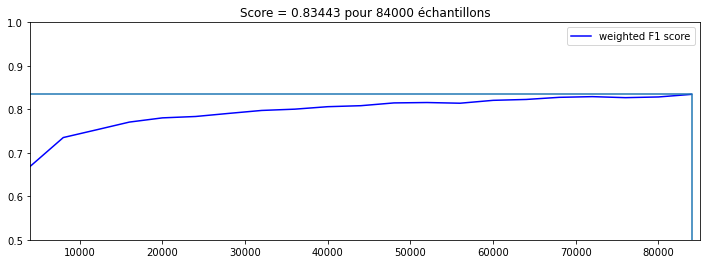

In [45]:
#
# Essai réduction de dimension
#
clf_redim_svc = make_pipeline(
    TfidfVectorizer(analyzer='word',
                  #strip_accents='ascii',
                  #tokenizer=tokenize_spacy,
                  #stop_words=french_stop_words_no_accent,
                  max_df=0.8,
                  min_df=2,
                  ngram_range=(1,2),
                  use_idf=True,
                  smooth_idf=True,
                  sublinear_tf=False,
                  binary=True,
                  ),
   SelectFromModel(LinearSVC(penalty="l1", dual=False,
                              tol=1e-4, max_iter=1500)),
    SVC(C=8,
        kernel='linear',
        decision_function_shape='ovo')
)


evaluate_tfclf_step_by_step("clf_redim_svc_learning", clf_redim_svc)